# 随机森林

基于随机森林模型实现NSL-KDD数据集上的二分类任务并实现投毒攻击

by 刘凡嘉

### 1. 数据读取和预处理

In [1]:
import pandas as pd
import numpy as np

In [2]:
#读入数据
def read_arrf(file):
    with open(file, encoding="utf-8") as f:
        header = []
        for line in f:
            if line.startswith("@attribute"):
                header.append(line.split()[1].replace("'", ""))
            elif line.startswith("@data"):
                break
        df = pd.read_csv(f, header = None)
        df.columns = header
    return df

train = read_arrf('NSL-KDD/KDDTrain+.arff')
test = read_arrf('NSL-KDD/KDDTest+.arff')
train

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,25,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
125969,8,udp,private,SF,105,145,0,0,0,0,...,244,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,30,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,8,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly


In [6]:
# 数据预处理
def preprocess_data(train, test):
    # 选出字符型和数值型的列
    str_cols = train.select_dtypes(include=['object']).columns
    real_cols = train.select_dtypes(include=['int', 'float64']).columns
    
    # 创建一个字典，将每个唯一值映射到一个整数
    unique_vals = {}
    for c in str_cols:
        unique = train[c].unique()
        for i, val in enumerate(unique):
            unique_vals[val] = i
    
        # 使用字典将分类变量进行编码
        train[c] = train[c].apply(lambda x: unique_vals[x])
        test[c] = test[c].apply(lambda x: unique_vals[x])
    
    # 定义一个函数，将数值型变量进行分桶处理
    def bucketize(col, n_bins=5):
        # 将变量按照值的大小进行排序
        col_sorted = sorted(col)
        n = len(col_sorted)
        # 计算每个分桶的大小
        bucket_size = n // n_bins
        # 初始化分桶边界
        boundaries = [col_sorted[0]]
        # 将每个分桶的边界加入到列表中
        for i in range(1, n_bins):
            boundary_index = i * bucket_size
            boundaries.append(col_sorted[boundary_index])
        boundaries.append(col_sorted[-1])
        # 将每个数值型变量的值根据分桶边界进行编码
        col_bucketized = []
        for x in col:
            for i in range(1, len(boundaries)):
                if x <= boundaries[i]:
                    col_bucketized.append(i-1)
                    break
        return col_bucketized
    
    # 对每个数值型变量进行分桶处理
    for c in real_cols:
        train[c] = bucketize(train[c], n_bins=5)
        test[c] = bucketize(test[c], n_bins=5)
    
    return train, test

train, test = preprocess_data(train, test)
train


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,0,0,0,4,0,0,0,0,0,...,2,2,2,4,0,0,0,4,0,0
1,0,4,0,0,2,0,0,0,0,0,...,0,0,4,4,0,0,0,0,0,0
2,0,0,0,2,0,0,0,0,0,0,...,2,1,2,0,0,3,3,0,0,2
3,0,0,1,0,3,4,0,0,0,0,...,3,3,0,3,4,3,3,0,4,0
4,0,0,1,0,3,3,0,0,0,0,...,3,3,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,0,0,2,0,0,0,0,0,0,...,2,1,3,0,0,3,3,0,0,2
125969,4,4,0,0,2,3,0,0,0,0,...,3,2,1,2,0,0,0,0,0,0
125970,0,0,3,0,4,3,0,0,0,0,...,2,2,3,0,0,3,0,4,0,0
125971,0,0,4,2,0,0,0,0,0,0,...,1,0,2,0,0,3,3,0,0,2


### 2. 建立决策树模型

In [21]:
class DecisionTreeDiscrete:
    def __init__(self,Data):
        self.Data = Data
        self.feature_value=dict([(feature, list(pd.unique(self.Data[feature]))) for feature in self.Data.iloc[:, :-1].columns])

    def Entropy(self,Data):
        label = Data.iloc[:, -1]
        label_class = label.value_counts()  
        Ent = 0
        for k in label_class.keys():
            p_k = label_class[k] / len(label)
            Ent += -p_k * np.log2(p_k)
        return Ent

    def InfoGain(self,Data,feature):
        Ent = self.Entropy(Data)
        feature_value = Data[feature].value_counts()  
        gain = 0

        for v in feature_value.keys():
            ratio = feature_value[v] / Data.shape[0]
            Ent_v = self.Entropy(Data.loc[Data[feature] == v])

            gain += ratio * Ent_v
        return Ent - gain
    
    def SplitData(self,Data,feature,value):
        datasize = Data.shape[0]
        newData = pd.DataFrame(columns=Data.columns)
        for i in range(datasize):
            if Data.iloc[i][feature]==value:
                newData = newData.append(Data.iloc[i,:],ignore_index=True)
        newData.drop([feature],axis=1,inplace=True)
        return newData

    def MajorClass(self,Data):
        label = Data.iloc[:, -1]
        label_sort = label.value_counts(sort=True)
        return label_sort.keys()[0]


    def ChooseBestFeature(self,Data):
        res={}
        features = Data.columns[:-1]
        for fea in features:
            temp=self.InfoGain(Data,fea)
            res[fea]=temp
        res = sorted(res.items(), key=lambda x: x[1], reverse=True)
        return res[0][0]  

    def TreeGenerate(self,Data):
        label = Data.iloc[:, -1]
        # Data中样本同属同一类别
        if len(label.value_counts()) == 1:  
            return label.values[0]
        # 所有样本在所有属性上取值相同
        if all(len(Data[i].value_counts()) == 1 for i in Data.iloc[:, :-1].columns):
            return self.MajorClass(Data)
        # 属性集为空
        if len(Data.columns)==1:
            return self.MajorClass(Data)

        best_feature= self.ChooseBestFeature(Data)  
        Tree = {best_feature: {}}
        # 样本集为空
        exist_vals = pd.unique(Data[best_feature])  
        if len(exist_vals) != len(self.feature_value[best_feature]):  
            no_exist_attr = set(self.feature_value[best_feature]) - set(exist_vals)
            for no_feat in no_exist_attr:
                Tree[best_feature][no_feat] = self.MajorClass(Data)
        # 递归创建子树
        for item in pd.unique(Data[best_feature]):  
            d = Data.loc[Data[best_feature] == item]
            del (d[best_feature])
            Tree[best_feature][item] = self.TreeGenerate(d)
        return Tree

    def predict(self,Tree,test_data):
        first_feature = list(Tree.keys())[0]
        second_dict = Tree[first_feature]
        class_label = 1
        for key in second_dict.keys():
            if test_data[first_feature]==key:
                if type(second_dict[key]).__name__=='dict':
                    class_label = self.predict(second_dict[key],test_data)
                else:
                    class_label = second_dict[key]
        return class_label
    
    def accuracy(self,Tree,valdata):
        label = list(valdata.iloc[:,-1])
        num = valdata.shape[0]
        Preds = []
        correct_count = 0
        for i in range(num):
            pred = self.predict(Tree,valdata.iloc[i,:])
            Preds.append(pred)
            if label[i]==pred:
                correct_count+=1
        return correct_count


### 3. 建立随机森林模型

In [22]:
class RandomForest:
    def __init__(self, Data, n_trees, sample_size):
        self.Data = Data
        self.n_trees = n_trees
        self.sample_size = sample_size
    
    def ForestGenerate(self, Data):
        trees = []
        for i in range(self.n_trees):
            # 随机采样训练集
            sample = Data.sample(frac=self.sample_size, replace=True)
            # 创建决策树
            dt = DecisionTreeDiscrete(sample)
            print(f'Creating tree {i+1}')
            tree = dt.TreeGenerate(sample)
            trees.append(tree)
        return trees
    
    def predict(self, trees, test):
        preds = []
        dt = DecisionTreeDiscrete(test)
        print('Predicting...')
        for i in range(test.shape[0]):
            pred = 0
            for tree in trees:
                pred += dt.predict(tree, test.iloc[i,:])
            pred /= self.n_trees
            preds.append(pred)
        # 将预测结果转换为二分类结果
        preds = [1 if p >= 0.5 else 0 for p in preds]
        # 计算准确率
        correct_count = sum([1 if preds[i] == test.iloc[i,-1] else 0 for i in range(test.shape[0])])
        acc = correct_count / test.shape[0]
        return acc


### 4. 训练随机森林模型

In [23]:
n_trees = 9
sample_size = 0.5


In [14]:
import pickle

print(f'Parameters: n_trees={n_trees}, sample_size={sample_size}')
rf = RandomForest(train, n_trees, sample_size)
trees = rf.ForestGenerate(train)
with open(f'../model/RF_{n_trees}.pkl', 'wb') as f:
    pickle.dump(trees, f)
print('Model saved')


Parameters: n_trees=9, sample_size=0.5
Creating tree 1
Creating tree 2
Creating tree 3
Creating tree 4
Creating tree 5
Creating tree 6
Creating tree 7
Creating tree 8
Creating tree 9
Model saved


### 5. 模型测试评估

In [24]:
with open(f'../model/RF_{n_trees}.pkl', 'rb') as f:
    trees_test = pickle.load(f)

acc = rf.predict(trees_test, test)
print(f'Accuracy: {acc}')


Predicting...
Accuracy: 0.8654630943931867


### 6. 投毒攻击

In [26]:
# 设置不同的投毒率
poison_rates = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


In [ ]:
rf = RandomForest(train, n_trees, sample_size)

for rate in poison_rates:
    modified_data = train.copy()
    num_samples = int(rate / 100 * len(train))
    subset_df = modified_data.sample(n=num_samples, random_state=42).copy()
    subset_df['class'] = subset_df['class'].astype(pd.Int64Dtype())
    subset_df['class'] = subset_df['class'].apply(lambda x: 0 if x == 1 else 1)
    modified_data = pd.concat([train, subset_df], ignore_index=True)
    print(f'Poisoning {rate}% :')
    poisoned_trees = rf.ForestGenerate(modified_data)
    
    with open(f'../model/RF_{n_trees}_poisoned{rate}.pkl', 'wb') as f:
        pickle.dump(poisoned_trees, f)


In [27]:
# 测试并计算准确率
rf = RandomForest(train, n_trees, sample_size)
accuracy_list = []

with open(f'../model/RF_{n_trees}.pkl', 'rb') as f:
    trees_test = pickle.load(f)
acc = rf.predict(trees_test, test)
print(f'Poison Rate: 0%, Accuracy: {acc}')
accuracy_list.append(acc)

for rate in poison_rates:
    with open(f'../model/RF_{n_trees}_poisoned{rate}.pkl', 'rb') as f:
        poisoned_trees = pickle.load(f)
    acc = rf.predict(poisoned_trees, test)
    print(f"Poison Rate: {rate}%, Accuracy: {acc}")
    accuracy_list.append(acc)


Predicting...
Poison Rate: 0%, Accuracy: 0.8654630943931867
Predicting...
Poison Rate: 10%, Accuracy: 0.7902324343506033
Predicting...
Poison Rate: 20%, Accuracy: 0.7830908445706175
Predicting...
Poison Rate: 30%, Accuracy: 0.7629968062455642
Predicting...
Poison Rate: 40%, Accuracy: 0.7684528034066714
Predicting...
Poison Rate: 50%, Accuracy: 0.7816270404542228
Predicting...
Poison Rate: 60%, Accuracy: 0.7758161816891412
Predicting...
Poison Rate: 70%, Accuracy: 0.748403122782115
Predicting...
Poison Rate: 80%, Accuracy: 0.7496007806955287
Predicting...
Poison Rate: 90%, Accuracy: 0.6100514549325763
Predicting...
Poison Rate: 100%, Accuracy: 0.5088271823988645


### 7. 可视化曲线

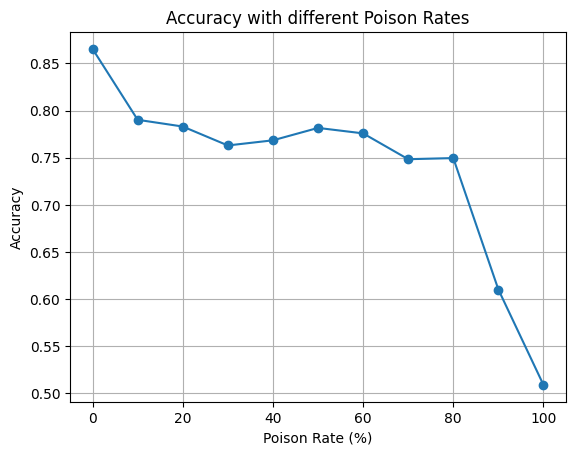

In [29]:
import matplotlib.pyplot as plt

poison_rates.insert(0, 0)
plt.plot(poison_rates, accuracy_list, marker='o')

plt.title('Accuracy with different Poison Rates')
plt.xlabel('Poison Rate (%)')
plt.ylabel('Accuracy')

plt.grid(True)

plt.show()
